# Part 1

Lets start with Collecting data as described in Week 4 Assignment

In [1]:
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
from pandas import json_normalize
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
geolocator = Nominatim(user_agent="ny_explorer")

In [3]:
def getlatlong(place):
    location = geolocator.geocode(place)
    loc_lat = location.latitude
    loc_long = location.longitude
    return (loc_lat, loc_long)

In [4]:
url_mum = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Mumbai"
html_mum = requests.get(url_mum).text
soup_mum = BeautifulSoup(html_mum, 'html5lib')

table_mum = []
for var in soup_mum.find('table').find_all('tr')[1:]:
    row = var.find_all('td')
    cell = {}
    cell['Area'] = row[0].text.split('\n')[0]
    cell['Location'] = row[1].text.split('\n')[0]
    cell['Latitude'] = float(row[2].text.split('\n')[0])
    cell['Longitude'] = float(row[3].text.split('\n')[0])
    table_mum.append(cell)
df_mum = pd.DataFrame(table_mum)

df_mum.set_index("Area", inplace=True)

df_mum.loc["Nehru Nagar", "Latitude"] = 19.0640
df_mum.loc["Nehru Nagar", "Longitude"] = 72.8826
df_mum.loc["Hindu colony", "Latitude"] = 19.0197
df_mum.loc["Hindu colony", "Longitude"] = 72.8479

df_mum.reset_index(inplace=True)

url_del = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_of_Delhi"
html_del = requests.get(url_del).text
soup_del = BeautifulSoup(html_del, 'html5lib')

table_del = []
n = soup_del.find('div', class_='mw-parser-output').find_all('h2')[1:-3]
for v in n:
    location = v.text.split('[')[0]
    ll = v.find_next_sibling().find_all('li')
    for i in ll:
        cell = {}
        area = i.text
        latlong = ""
        try:
            latlong = getlatlong(area + ', Delhi')
            cell['Location'] = location
            cell['Area'] = area
            cell['Latitude'] = latlong[0]
            cell['Longitude'] = latlong[1]
            table_del.append(cell)
        except:
            cell['Location'] = location
            cell['Area'] = area
            cell['Latitude'] = 0
            cell['Longitude'] = 0
            table_del.append(cell)

df_del = pd.DataFrame(table_del)

df_del.set_index("Area", inplace=True)

## Fixing Incorrect Values
df_del.loc["Rohini Sub City", "Latitude"] = 28.7383
df_del.loc["Rohini Sub City", "Longitude"] = 77.0822
df_del.loc["Jamia Nagar", "Latitude"] = 28.5539
df_del.loc["Jamia Nagar", "Longitude"] = 77.2956
df_del.loc["Dwarka Sub City", "Latitude"] = 28.5823
df_del.loc["Dwarka Sub City", "Longitude"] = 77.0500
df_del.loc["Kamal Hans Nagar", "Latitude"] = 28.680556
df_del.loc["Kamal Hans Nagar", "Longitude"] = 77.203611
df_del.loc["Rajender Nagar", "Latitude"] = 28.6372
df_del.loc["Rajender Nagar", "Longitude"] = 77.1824
df_del.loc["Sagar Pur", "Latitude"] = 28.6007
df_del.loc["Sagar Pur", "Longitude"] = 77.1031

df_del.reset_index(inplace=True)

# Part 2

Display the Data collected

#### **Mumbai**

In [5]:
df_mum

,Area,Location,Latitude,Longitude
0,Amboli,"Andheri,Western Suburbs",19.129300,72.843400
1,"Chakala, Andheri",Western Suburbs,19.111388,72.860833
2,D.N. Nagar,"Andheri,Western Suburbs",19.124085,72.831373
3,Four Bungalows,"Andheri,Western Suburbs",19.124714,72.827210
4,Lokhandwala,"Andheri,Western Suburbs",19.130815,72.829270
...,...,...,...,...
88,Parel,South Mumbai,18.990000,72.840000
89,Gowalia Tank,"Tardeo,South Mumbai",18.962450,72.809703
90,Dava Bazaar,South Mumbai,18.946882,72.831362
91,Dharavi,Mumbai,19.040208,72.850850


#### **Delhi**

Geocoder was used to gather geo location data on Delhi areas as the wikipedia page did not have any values for it

In [6]:
df_del

,Area,Location,Latitude,Longitude
0,Adarsh Nagar,North West Delhi,28.716580,77.170422
1,Ashok Vihar,North West Delhi,28.699453,77.184826
2,Begum Pur,North West Delhi,28.725503,77.058371
3,Karala,North West Delhi,28.735140,77.032511
4,Narela,North West Delhi,28.842610,77.091835
...,...,...,...,...
120,Rajouri Garden,West Delhi,28.651190,77.124260
121,Tihar Village,West Delhi,28.634636,77.107112
122,Tilak Nagar,West Delhi,28.636548,77.096496
123,Vikas Nagar,West Delhi,28.644009,77.054470


### Venue Data

Foursquare location data gave information about the list of venues within a 1 km radius of each borough. This is a reasonable distance to understand the characteristics of the neighbourhood.

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
## Set Foursquare Credentials
CLIENT_ID = 'L4JLROSOYW4ML2GX1IS2NGRHJ2PLHWXGJ3YN0WZ5N2XXNUHC'
CLIENT_SECRET = '3PXERPTKRYQG1RRSZGVY41UENAMYMRX1YX1X0LUVHKB1I3NY'
VERSION = '20180605'
LIMIT = 100
#set radius to 1 Km
Radius = 1000

In [9]:
venues_mum = getNearbyVenues(names=df_mum['Area'],
                            latitudes=df_mum['Latitude'],
                            longitudes=df_mum['Longitude'],
                            radius=Radius)

In [10]:
venues_del = getNearbyVenues(names=df_del['Area'],
                            latitudes=df_del['Latitude'],
                            longitudes=df_del['Longitude'],
                            radius=Radius)

In [11]:
def nearbyvenues_count(venues_df, area):
    venues_count = venues_df
    venues_count = venues_count.rename(columns={'Venue Category': 'Category'})
    venues_count = venues_count.groupby(['Area']).Category.value_counts().to_frame("Counts")
    fig, ax = plt.subplots(1,1,figsize=(20, 7)) 
    fig.subplots_adjust(left=0.115, right=0.88)
    venues_plot =  venues_count['Counts'].loc[area][:10].head(10) 
    pos = np.arange(len(venues_plot))
    ax.set_title(area,size=20)
    freqchart = ax.barh(pos, venues_plot,align='center',height=0.5,tick_label=venues_plot.index)
    
    return freqchart

Now lets visualize the top venue categories in two most popular areas of the cities

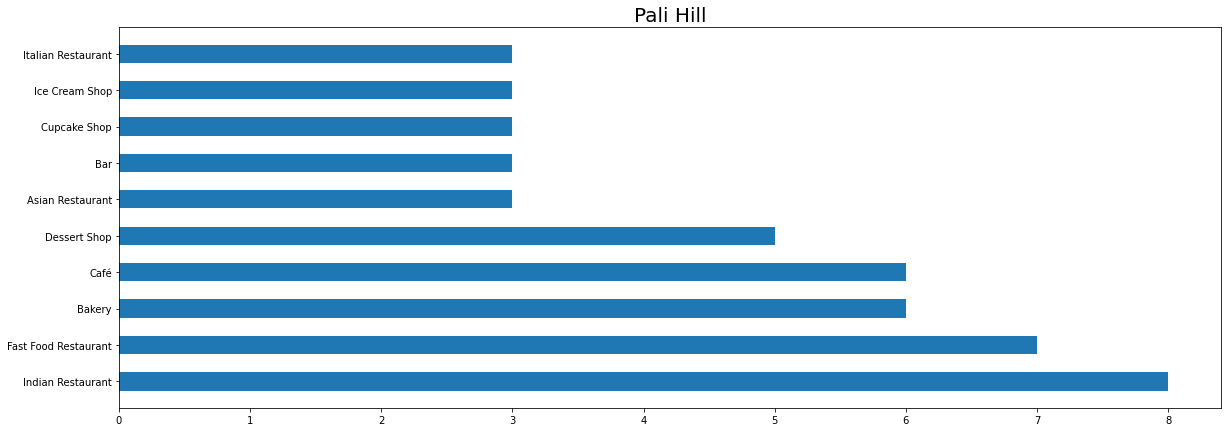

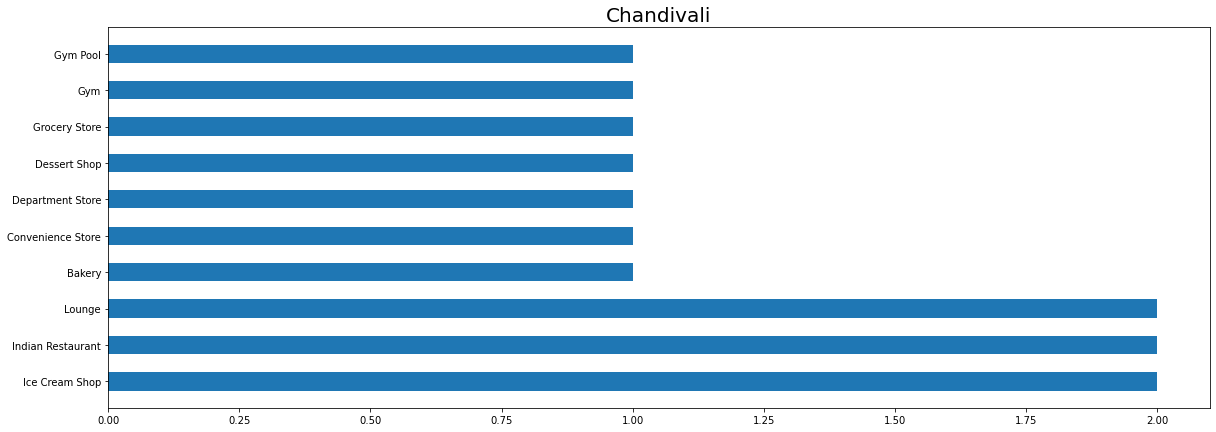

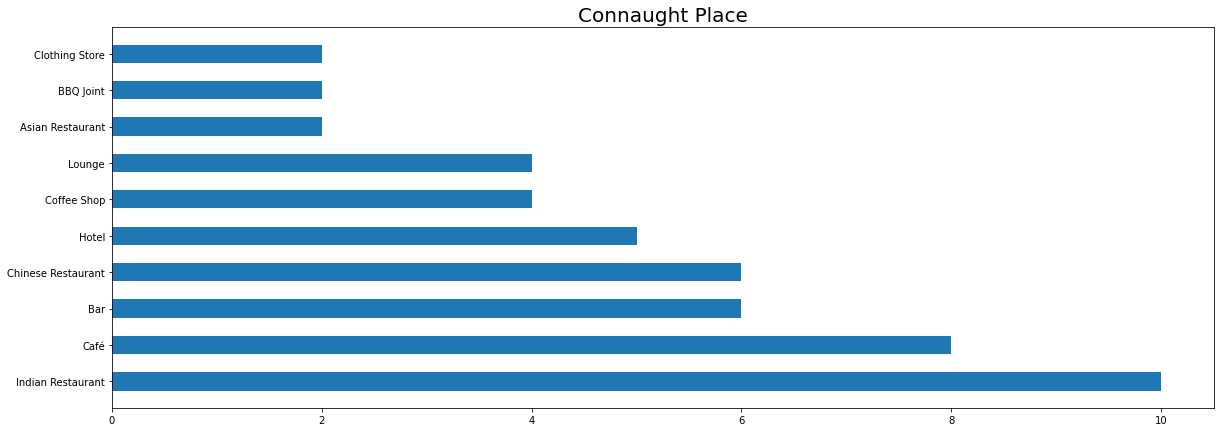

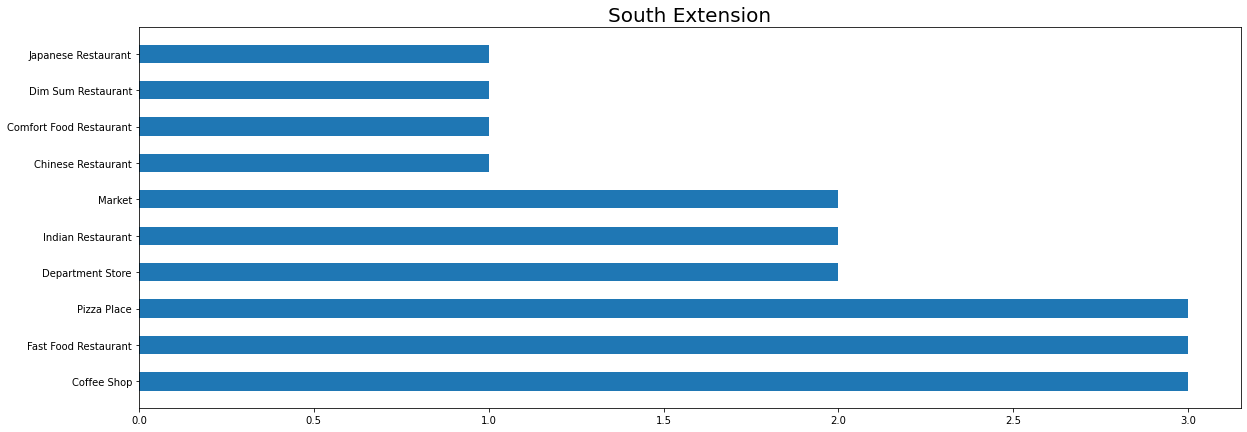

In [12]:
major_areas_mum = ['Pali Hill', 'Chandivali']
major_areas_del = ['Connaught Place', 'South Extension']

for i in major_areas_mum:
    nearbyvenues_count(venues_mum, i)
    
for j in major_areas_del:
    nearbyvenues_count(venues_del, j)

In order to explore the venue data in a more comprehensive way and further use it for analysis, foursquare venue data was arranged into pandas data frame as follows:

- First, create a data-frame with pandas one hot encoding for each of the venue categories
- Obtain the mean of each one-hot encoded venue categories using pandas groupby method on the borough column
- Use the venue category mean to obtain a venue based data frame for each city giving the ten most common venues for each borough

In [13]:
venues_mum_oh = pd.get_dummies(venues_mum['Venue Category'], prefix="", prefix_sep="")
venues_del_oh = pd.get_dummies(venues_del['Venue Category'], prefix="", prefix_sep="")

venues_mum_oh['Area'] = venues_mum['Area']
venues_del_oh['Area'] = venues_del['Area']

fixed_columns_mum = [venues_mum_oh.columns[-1]] + list(venues_mum_oh.columns[:-1])
fixed_columns_del = [venues_del_oh.columns[-1]] + list(venues_del_oh.columns[:-1])

venues_mum_oh = venues_mum_oh[fixed_columns_mum]
venues_del_oh = venues_del_oh[fixed_columns_del]

venues_grouped_mum = venues_mum_oh.groupby('Area').mean().reset_index()
venues_grouped_del = venues_del_oh.groupby('Area').mean().reset_index()

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def venues_grouped_to_sorted(df, label, n=10):
    indicators = ['st', 'nd', 'rd']
    # create columns according to number of top venues
    columns = [label]
    for ind in np.arange(n):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted[label] = df[label]

    for ind in np.arange(df.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], n)

    return neighborhoods_venues_sorted

In [15]:
venues_sorted_mum = venues_grouped_to_sorted(df=venues_grouped_mum, label='Area')
venues_sorted_del = venues_grouped_to_sorted(df=venues_grouped_del, label='Area')

In [16]:
venues_sorted_mum

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarey Milk Colony,Indian Restaurant,Gym / Fitness Center,Restaurant,Resort,Golf Course,Hotel,Farm,Café,Zoo,Dim Sum Restaurant
1,Agripada,Indian Restaurant,Bakery,Coffee Shop,Gym,Zoo,Golf Course,Pizza Place,Nightclub,Movie Theater,Cupcake Shop
2,Altamount Road,Bakery,Chinese Restaurant,Bar,Indian Restaurant,Café,Fast Food Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Snack Place
3,Amboli,Indian Restaurant,Bar,Asian Restaurant,Pizza Place,Coffee Shop,Chinese Restaurant,Pub,Falafel Restaurant,Bowling Alley,Smoke Shop
4,Amrut Nagar,Café,Lounge,Indian Restaurant,Clothing Store,Fast Food Restaurant,Pizza Place,Electronics Store,Vegetarian / Vegan Restaurant,Diner,Chinese Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
87,Vikhroli,Comedy Club,Soccer Field,Pool,Bakery,Scenic Lookout,Zoo,Dim Sum Restaurant,Farm,Falafel Restaurant,Factory
88,Vile Parle,Indian Restaurant,Café,Hotel,Bar,Restaurant,Spa,Snack Place,Coffee Shop,Sandwich Place,Lounge
89,Virar,Fast Food Restaurant,Pizza Place,Department Store,Theme Park,Indian Restaurant,Indian Chinese Restaurant,Donut Shop,Diner,Dumpling Restaurant,Dhaba
90,Walkeshwar,Indian Restaurant,Gym,Hotel,Lighthouse,Department Store,Ice Cream Shop,Dessert Shop,Coffee Shop,Creperie,Donut Shop


In [17]:
venues_sorted_del

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Pool Hall,Mobile Phone Shop,Train Station,Ice Cream Shop,Convenience Store,Indian Restaurant,Light Rail Station,Fried Chicken Joint,French Restaurant,Frozen Yogurt Shop
1,Alaknanda,Coffee Shop,Restaurant,Indian Restaurant,Market,BBQ Joint,Convenience Store,Dessert Shop,Plaza,Sandwich Place,Park
2,Anand Vihar,Clothing Store,Hotel,Multiplex,Pizza Place,Wine Shop,Movie Theater,Bus Station,Shopping Mall,Café,Garden
3,Ashok Nagar,Fast Food Restaurant,Indian Restaurant,Pizza Place,Donut Shop,Coffee Shop,Restaurant,Café,Shopping Mall,Multiplex,Clothing Store
4,Ashok Vihar,Donut Shop,Asian Restaurant,Snack Place,Frozen Yogurt Shop,Sandwich Place,South Indian Restaurant,Coffee Shop,Fast Food Restaurant,Indian Restaurant,Pizza Place
...,...,...,...,...,...,...,...,...,...,...,...
118,Vikaspuri,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Men's Store,Park,Flea Market,Food & Drink Shop,Garden Center,Garden
119,Vishwas Nagar,Gym,Hotel,Pizza Place,Big Box Store,Shopping Mall,Food,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint
120,Vivek Vihar,Juice Bar,Indian Restaurant,BBQ Joint,Track,Athletics & Sports,Asian Restaurant,Metro Station,Shop & Service,Pool,Frozen Yogurt Shop
121,Wazirabad,Park,ATM,Chocolate Shop,Motorcycle Shop,Garden Center,Garden,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant


I performed a clustering analysis using the ‘k-means’ algorithm in order to categorise similar areas into clusters based on the similarities provided by the venue categories. To gain some understanding, I decided to do some investigation into the number of clusters (k) to be used as follows:

> ***Elbow method***: I tried to determine the effective number of clusters (k) using the elbow method for Mumbai clustering analysis and saw a small kink around k = 8 (although not clear and sharp). The elbow method uses Within-Cluster-Sum of Squared Errors (WSS) for different values of k and one can choose the value of k for which WSS starts to diminish and can be seen as an elbow in the WSS-versus-k plot. Similarly for Delhi, the kink can be noticed at k=5. I decided to categorise Mumbai areas into 8 set of clusters and Delhi neighbourhoods into 5 set of clusters for the purpose of our analysis. It might be useful to look into a more detailed analysis to optimise k in the future for such studies.

In [18]:
def getKmeanschart(df_grouped, k_range):
    kclusters = range(1,k_range)
    sse = []
    df_clustering = df_grouped.drop('Area', 1)
    for k in kclusters:
        k_means = KMeans(n_clusters = k, n_init=12)
        k_means.fit(df_clustering)
        sse.append(k_means.inertia_)
    plt.xlabel('K')
    plt.ylabel('Sum of squared errors')
    plt.title("SSE error plot for Kmeans")
    plt.plot(kclusters, sse)

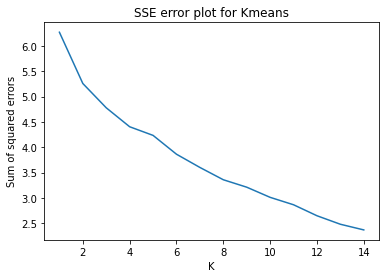

In [19]:
getKmeanschart(venues_grouped_mum,  k_range=15)

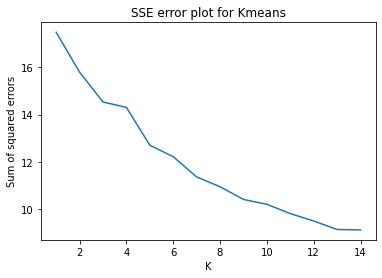

In [20]:
getKmeanschart(venues_grouped_del,  k_range=15)

In [21]:
kcluster_mum = 8
kcluster_del = 5

venues_clustering_mum = venues_grouped_mum.drop('Area', 1)
venues_clustering_del = venues_grouped_del.drop('Area', 1)

k_means_mum = KMeans(n_clusters = kcluster_mum)
k_means_del = KMeans(n_clusters = kcluster_del)

k_means_mum.fit(venues_clustering_mum)
k_means_del.fit(venues_clustering_del)

venues_sorted_mum.insert(0, 'Cluster Labels', k_means_mum.labels_)
venues_sorted_del.insert(0, 'Cluster Labels', k_means_del.labels_)

merged_mum = df_mum
merged_del = df_del

merged_mum = merged_mum.join(venues_sorted_mum.set_index('Area'), on='Area')
merged_del = merged_del.join(venues_sorted_del.set_index('Area'), on='Area')

In [22]:
def getMergedPlot(df_merged, m_lat, m_long, kclusters):
    map_clusters = folium.Map(location=[m_lat, m_long], zoom_start=10)

    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    markers_colors = []
    for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Area'], df_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    return map_clusters

In [23]:
latlong_mum = getlatlong("Mumbai, IN")
merged_mum.dropna(axis=0, inplace=True)
merged_mum['Cluster Labels'] = merged_mum['Cluster Labels'].map(int)
getMergedPlot(merged_mum, latlong_mum[0], latlong_mum[1], kcluster_mum)

In [24]:
latlong_del = getlatlong("Delhi, IN")
merged_del.dropna(axis=0, inplace=True)
merged_del['Cluster Labels'] = merged_del['Cluster Labels'].map(int)
getMergedPlot(merged_del, latlong_del[0], latlong_del[1], kcluster_mum)

# Discussion of Results

Some of the inferences which were drawn from the explanatory analysis are:

Initial exploration of the Foursquare venue data revealed that Indian Restaurants, cafes, pubs and juice bars are the most common venues in main areas in Mumbai. Similarly Clothing, food restaurants and hotels were the most common venues seen in main areas of Delhi.

Further, machine learning analysis of the venue based data revealed most of the areas of Mumbai can be grouped together into one cluster. The most common venues in such boroughs were always cafes, pubs, shops or restaurants followed by some kind of clothing, convenience stores or pharmacies. Delhi was categorised into five separate clusters in total with two of its clusters amounting for the majority. Although the most common venue in both the clusters was always a Indian restaurant, it was followed by a high number of Italian restaurants, hotels, and cafes in the first cluster and variations of other cuisine restaurants, bars, bistros, clothing stores or supermarkets in the subsequent cluster.

The most common type of venues in either of the cities are mostly restaurants, cafes, hotels, pubs/bars, clothing stores or parks. This in a way highlights that how similar the cities of Mumbai and Delhi are in terms of services being offered.

> One can further use the venue data to compare the cities is a more comprehensive way where one can also explore different levels of spatial aggregation, namely grids, neighbourhoods, and the city as a whole. The level of spatial aggregation can be an important factor when characterising a city in terms of its venues.

Some of the questions one can answer with different levels of spatial aggregation could be:

- How are the venue categories distributed inside an area, i.e., is the area more of a residential or a commercial one.
- Which city has the highest number of each of the amenities (bars, restaurants, parks, universities, libraries, shopping centres, etc.)

# Conclusion

To summarise, analysing cities using venue based data from Foursquare lead to an overall understanding of the type of venues in each area and presented some of the key features of the cities but the level of data is not adequate to provide a comprehensive analysis for a city-to-city comparison. For a potential interested person (job-seeker or person deciding to move to either of the cities) or a bigger clientele like a business corporation or city planners, one would need to do a more detailed analysis adding features such as rents, salaries, transportation, cost of living, growth rate, economy, etc.